In [8]:
%pwd
%matplotlib inline

# Import necessary libraries
# neccasary packages are loaded
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import zipfile
from IPython.display import display, Markdown
from ast import literal_eval
from wordcloud import WordCloud

import random
import os

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

## Introductory words about the dataset

The RecipeNLG dataset (Poznań University of Technology) is an expansion of the Recipe1M+ dataset, offering a significantly larger selection of recipes. Unlike its predecessor, this dataset does not prioritize linking cooking instructions with their corresponding images and instead emphasizes the recipe text, structure, and logic. This updated collection contains over one million newly preprocessed and deduplicated recipes, making it the largest publicly accessible dataset in its field.

The dataset is availabe on Kaggle <https://www.kaggle.com/datasets/saldenisov/recipenlg>.

## Dataset Cleaning & Processing


This cell does not to be executed because a smaller dataset of ~50000 samples has been generated from the complete 1M+ dataset.

In [6]:
# import os
# current_path = os.getcwd()
# print(current_path)

# os.chdir('../dataset_full/')
# path_base_dataset = os.getcwd()
# print(path_base_dataset)

# os.chdir('../notebooks/')
# path_base_notebook = os.getcwd()
# print(path_base_notebook)

# dataset_path = path_base_dataset + '/dataset_recipes.csv'
# print(dataset_path)

# df_original = pd.read_csv(dataset_path)
# df_original.head()


c:\Batool_Data (2024)\Privat\BT_Related to Durham College\Semester #2\github\Personalized_Recipe_Recommender\notebooks
c:\Batool_Data (2024)\Privat\BT_Related to Durham College\Semester #2\github\Personalized_Recipe_Recommender\dataset_full
c:\Batool_Data (2024)\Privat\BT_Related to Durham College\Semester #2\github\Personalized_Recipe_Recommender\notebooks
c:\Batool_Data (2024)\Privat\BT_Related to Durham College\Semester #2\github\Personalized_Recipe_Recommender\dataset_full/dataset_recipes.csv


In [69]:
# df_original_old = df_original[:]

In [72]:
# NUM_DATA_SAMPLES = 50000
# df = df_original.sample(NUM_DATA_SAMPLES, random_state=44)
# df.head()
# path_base = '/teamspace/studios/this_studio/Personalized_Recipe_Recommender/dataset/'
# file_name = 'sampled_dataset_' + str(NUM_DATA_SAMPLES) + '.csv'
# sampled_data_file_path = path_base + file_name
# # df.to_csv('/teamspace/studios/this_studio/Personalized_Recipe_Recommender/dataset/sampled_dataset_10000.csv')
# df.to_csv(sampled_data_file_path)

### Loading the sampled dataset

In [11]:
import os
current_path = os.getcwd()
print(current_path)

os.chdir('../dataset/')
path_base_dataset = os.getcwd()
print(path_base_dataset)

os.chdir('../notebooks/')
path_base_notebook = os.getcwd()
print(path_base_notebook)

NUM_DATA_SAMPLES = 50000
file_name = '/sampled_dataset_' + str(NUM_DATA_SAMPLES) + '.csv'
sampled_data_file_path = path_base_dataset + file_name

df = pd.read_csv(sampled_data_file_path)
df.head()


c:\Batool_Data (2024)\Privat\BT_Related to Durham College\Semester #2\github\Personalized_Recipe_Recommender\notebooks
c:\Batool_Data (2024)\Privat\BT_Related to Durham College\Semester #2\github\Personalized_Recipe_Recommender\dataset
c:\Batool_Data (2024)\Privat\BT_Related to Durham College\Semester #2\github\Personalized_Recipe_Recommender\notebooks


Unnamed: 0       ID                                             name  \
0     1254789  1254789  Bacon, Lettuce, Tomato And Fried Egg Sandwiches   
1     2162678  2162678                      Sauteed Bay Scallops Recipe   
2      832049   832049                 No Fuss No Mess Chicken And Rice   
3     1396186  1396186                           Baked Chicken Shawarma   
4     1322877  1322877                        Salt-And-Pepper Biscuits    

                                         ingredients  \
0  ["4 slices bacon, halved", "4 None eggs", "4 N...   
1  ["2 pound bay scallops", "1/4 pound butter, me...   
2  ["1 c. uncooked rice", "1 chicken, cut up", "1...   
3  ["2 teaspoons coriander", "1 teaspoon allspice...   
4  ["3/4 cup sour cream", "4 tablespoons heavy cr...   

                                           procedure  \
0  ["Lightly coat a nonstick frying pan and place...   
1  ["Saute/fry onions and parsley in butter.", "R...   
2  ["Place rice in oblong pan.", "Place chicken o...   
3  ["In a large bowl combine coriander, allspice,...   
4  ["Preheat oven to 425\u00b0F. Whisk sour cream...   

                                                link     source  \
0            recipes-plus.com/api/v2.0/recipes/37658   Gathered   
1  cookeatshare.com/recipes/sauteed-bay-scallops-...  Recipes1M   
2    www.cookbooks.com/Recipe-Details.aspx?id=334186   Gathered   
3    food52.com/recipes/41562-baked-chicken-shawarma   Gathered   
4  www.epicurious.com/recipes/food/views/salt-and...   Gathered   

                                                 NER  
0  ["bacon", "eggs", "buns", "tomatoes", "mayonna...  
1  ["bay scallops", "butter", "onions", "parsley"...  
2  ["rice", "chicken", "cream of mushroom soup", ...  
3  ["coriander", "allspice", "cumin", "ground gin...  
4  ["sour cream", "heavy cream", "baking powder",...

### List of Columns

In [22]:
df.columns

Index(['Unnamed: 0', 'title', 'ingredients', 'directions', 'link', 'source',
       'NER'],
      dtype='object')

The dataset consists of 7 columns:
- id (int): ID.
- title (str): Title of the recipe.
- ingredients (list of str): Ingredients.
- directions (list of str): Instruction steps.
- link (str): URL link.
- source (ClassLabel): Origin of each recipe record, with possible value {"Gathered", "Recipes1M"}:
    1. "Gathered" (0): Additional recipes gathered from multiple cooking web pages using automated scripts in a web scraping process.
    2. "Recipes1M" (1): Recipes from the "Recipe1M+" dataset.

### Column Renaming

df.head(10)

In [75]:
df.rename(columns={'Unnamed: 0': 'ID','directions': 'procedure', 'title': 'name'},inplace=True, errors='raise')

## Data Preparation

In [76]:
df.head()

ID                                             name  \
1254789  1254789  Bacon, Lettuce, Tomato And Fried Egg Sandwiches   
2162678  2162678                      Sauteed Bay Scallops Recipe   
832049    832049                 No Fuss No Mess Chicken And Rice   
1396186  1396186                           Baked Chicken Shawarma   
1322877  1322877                        Salt-And-Pepper Biscuits    

                                               ingredients  \
1254789  ["4 slices bacon, halved", "4 None eggs", "4 N...   
2162678  ["2 pound bay scallops", "1/4 pound butter, me...   
832049   ["1 c. uncooked rice", "1 chicken, cut up", "1...   
1396186  ["2 teaspoons coriander", "1 teaspoon allspice...   
1322877  ["3/4 cup sour cream", "4 tablespoons heavy cr...   

                                                 procedure  \
1254789  ["Lightly coat a nonstick frying pan and place...   
2162678  ["Saute/fry onions and parsley in butter.", "R...   
832049   ["Place rice in oblong pan.", "Place chicken o...   
1396186  ["In a large bowl combine coriander, allspice,...   
1322877  ["Preheat oven to 425\u00b0F. Whisk sour cream...   

                                                      link     source  \
1254789            recipes-plus.com/api/v2.0/recipes/37658   Gathered   
2162678  cookeatshare.com/recipes/sauteed-bay-scallops-...  Recipes1M   
832049     www.cookbooks.com/Recipe-Details.aspx?id=334186   Gathered   
1396186    food52.com/recipes/41562-baked-chicken-shawarma   Gathered   
1322877  www.epicurious.com/recipes/food/views/salt-and...   Gathered   

                                                       NER  
1254789  ["bacon", "eggs", "buns", "tomatoes", "mayonna...  
2162678  ["bay scallops", "butter", "onions", "parsley"...  
832049   ["rice", "chicken", "cream of mushroom soup", ...  
1396186  ["coriander", "allspice", "cumin", "ground gin...  
1322877  ["sour cream", "heavy cream", "baking powder",...

In [77]:
df.to_csv(sampled_data_file_path)

### Setting the types

In [78]:
df = df.astype({'ID': int, 
                'name': str,
                'ingredients': 'object', 
                'procedure': 'object', 
                'link': str,
                'source': 'category', 
                'NER': 'object'})

### Adding Extra Columns
The variations in ingredients and their quantities across recipes, as well as the number of steps in each recipe, are of interest.


In [79]:
df['n_NER'] = df['NER'].apply(len)
df['n_procedures'] = df['procedure'].apply(len)

In [80]:
df.head()

ID                                             name  \
1254789  1254789  Bacon, Lettuce, Tomato And Fried Egg Sandwiches   
2162678  2162678                      Sauteed Bay Scallops Recipe   
832049    832049                 No Fuss No Mess Chicken And Rice   
1396186  1396186                           Baked Chicken Shawarma   
1322877  1322877                        Salt-And-Pepper Biscuits    

                                               ingredients  \
1254789  ["4 slices bacon, halved", "4 None eggs", "4 N...   
2162678  ["2 pound bay scallops", "1/4 pound butter, me...   
832049   ["1 c. uncooked rice", "1 chicken, cut up", "1...   
1396186  ["2 teaspoons coriander", "1 teaspoon allspice...   
1322877  ["3/4 cup sour cream", "4 tablespoons heavy cr...   

                                                 procedure  \
1254789  ["Lightly coat a nonstick frying pan and place...   
2162678  ["Saute/fry onions and parsley in butter.", "R...   
832049   ["Place rice in oblong pan.", "Place chicken o...   
1396186  ["In a large bowl combine coriander, allspice,...   
1322877  ["Preheat oven to 425\u00b0F. Whisk sour cream...   

                                                      link     source  \
1254789            recipes-plus.com/api/v2.0/recipes/37658   Gathered   
2162678  cookeatshare.com/recipes/sauteed-bay-scallops-...  Recipes1M   
832049     www.cookbooks.com/Recipe-Details.aspx?id=334186   Gathered   
1396186    food52.com/recipes/41562-baked-chicken-shawarma   Gathered   
1322877  www.epicurious.com/recipes/food/views/salt-and...   Gathered   

                                                       NER  n_NER  \
1254789  ["bacon", "eggs", "buns", "tomatoes", "mayonna...     51   
2162678  ["bay scallops", "butter", "onions", "parsley"...     73   
832049   ["rice", "chicken", "cream of mushroom soup", ...     93   
1396186  ["coriander", "allspice", "cumin", "ground gin...    219   
1322877  ["sour cream", "heavy cream", "baking powder",...    130   

         n_procedures  
1254789           335  
2162678           380  
832049            166  
1396186           860  
1322877           936

### Cleaning Empty
First lets copy the df

In [81]:
df_old = df[:]

#### Cleaning n_NER column

In [82]:
df = df[df['n_NER'] > 0]

#### Cleaning n_procedures column

In [83]:
df = df[df['n_procedures'] > 0]

Dataset Head:
               ID                                             name  \
1254789  1254789  Bacon, Lettuce, Tomato And Fried Egg Sandwiches   
2162678  2162678                      Sauteed Bay Scallops Recipe   
832049    832049                 No Fuss No Mess Chicken And Rice   
1396186  1396186                           Baked Chicken Shawarma   
1322877  1322877                        Salt-And-Pepper Biscuits    

                                               ingredients  \
1254789  ["4 slices bacon, halved", "4 None eggs", "4 N...   
2162678  ["2 pound bay scallops", "1/4 pound butter, me...   
832049   ["1 c. uncooked rice", "1 chicken, cut up", "1...   
1396186  ["2 teaspoons coriander", "1 teaspoon allspice...   
1322877  ["3/4 cup sour cream", "4 tablespoons heavy cr...   

                                                 procedure  \
1254789  ["Lightly coat a nonstick frying pan and place...   
2162678  ["Saute/fry onions and parsley in butter.", "R...   
832049   ["

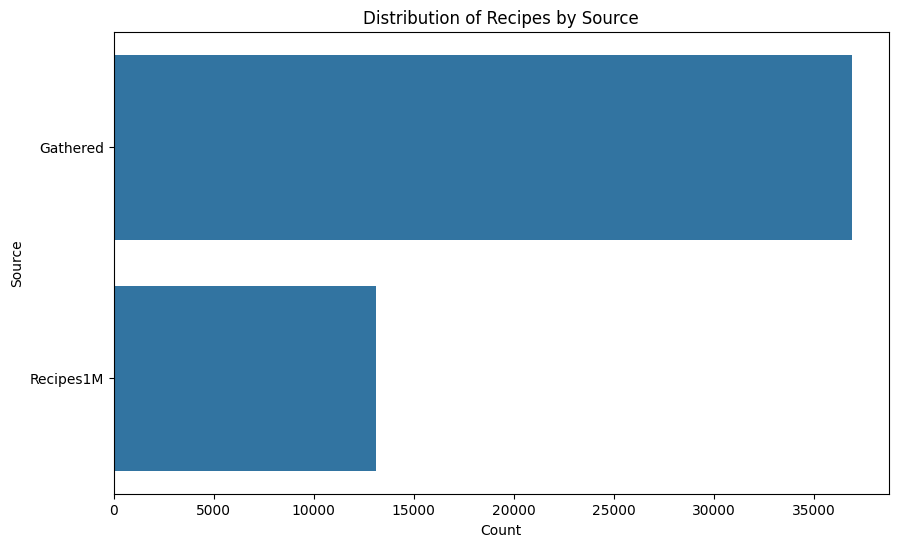

In [84]:
# Display the first few rows of the dataset
print("Dataset Head:\n", df.head())

# Display basic information about the dataset
print("\nDataset Info:\n")
df.info()

# Display summary statistics of the dataset
print("\nDataset Description:\n", df.describe())

# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())

# Check for duplicates
print("\nDuplicate Rows:\n", df.duplicated().sum())

# Visualize distribution of recipes
plt.figure(figsize=(10, 6))
sns.countplot(y=df['source'])
plt.title('Distribution of Recipes by Source')
plt.xlabel('Count')
plt.ylabel('Source')
plt.show()


In [33]:
# Remove duplicate rows
df = df.drop_duplicates()

# Handling missing values
# For simplicity, we will drop rows with missing values. 
# Depending on the data, you may choose to impute missing values.
df = df.dropna()

# Verify that there are no more missing values or duplicates
print("\nMissing Values After Cleaning:\n", df.isnull().sum())
print("\nDuplicate Rows After Cleaning:\n", df.duplicated().sum())



Missing Values After Cleaning:
 ID              0
name            0
ingredients     0
procedure       0
link            0
source          0
NER             0
n_NER           0
n_procedures    0
dtype: int64

Duplicate Rows After Cleaning:
 0


## Data Analysis

### Unique Values of Sources

In [85]:
df['source'].unique()

['Gathered', 'Recipes1M']
Categories (2, object): ['Gathered', 'Recipes1M']

### Unique Values of Recipes

In [86]:
unique_names = len(df['name'].unique())
number_entries = len(df)
number_entries_old = len(df_old)
display(Markdown(f'Number of all entries: {number_entries:.0f} vs Number of all entries before cleaning: {number_entries_old :.0f}'))
display(Markdown(f'Number of unique names: {unique_names :.0f}'))

Number of all entries: 50000 vs Number of all entries before cleaning: 50000

Number of unique names: 41296

### Distribution of Number Ingredients by Sources

/tmp/ipykernel_4475/809033254.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_n_ingridients = df.groupby('source')['n_NER'].mean()


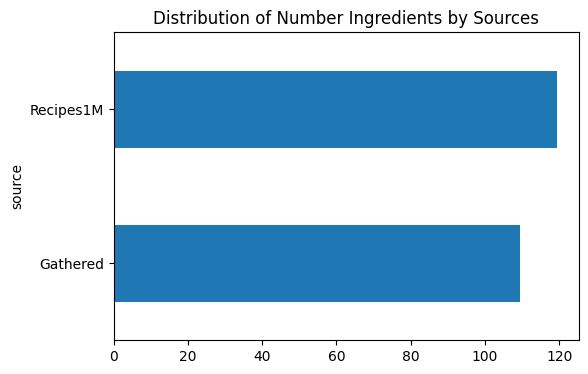

In [87]:
average_n_ingridients = df.groupby('source')['n_NER'].mean()
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Distribution of Number Ingredients by Sources')
average_n_ingridients.plot(kind='barh', stacked=False, ax=ax)
# Show the chart
plt.show()

### Distribution of Number Procedure Steps by Sources

/tmp/ipykernel_4475/3374620337.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_n_procedures = df.groupby('source')['n_procedures'].mean()


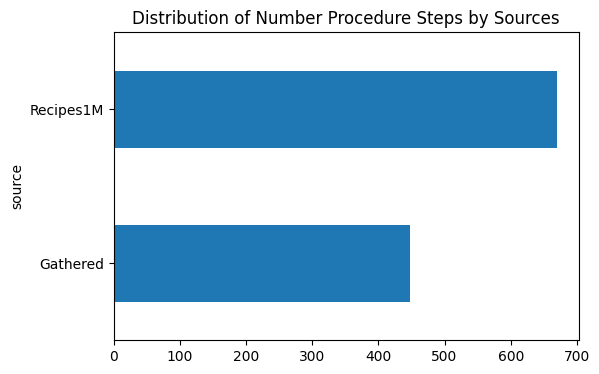

In [88]:
average_n_procedures = df.groupby('source')['n_procedures'].mean()
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Distribution of Number Procedure Steps by Sources')
average_n_procedures.plot(kind='barh', stacked=False, ax=ax)
# Show the chart
plt.show()

## Ingredients

### List of ingredients

In [89]:
NER_exploded = df.explode('NER')
print(f"NER_explode len {len(NER_exploded)}")

ingredients = NER_exploded['NER']
print(ingredients[0:10])

# get the unique values of the exploded column
unique_NER_values = NER_exploded['NER'].unique()
print(len(unique_NER_values))

NER_explode len 50000
1254789    ["bacon", "eggs", "buns", "tomatoes", "mayonna...
2162678    ["bay scallops", "butter", "onions", "parsley"...
832049     ["rice", "chicken", "cream of mushroom soup", ...
1396186    ["coriander", "allspice", "cumin", "ground gin...
1322877    ["sour cream", "heavy cream", "baking powder",...
413822     ["hamburger", "egg", "bread crumbs", "onion", ...
513148     ["stew meat", "cabbage", "onion", "green bell ...
2117175    ["chicken broth", "water", "chicken", "onion",...
1330196    ["pork sparerib", "black bean sauce", "Chinese...
1888200    ["shell pasta", "red pepper", "green onion", "...
Name: NER, dtype: object
49799


In [91]:
display(Markdown(f'Number of unique ingridients: {len(unique_NER_values) :.0f}'))

Number of unique ingridients: 49799

In [92]:
print(unique_NER_values[:200])

['["bacon", "eggs", "buns", "tomatoes", "mayonnaise"]'
 '["bay scallops", "butter", "onions", "parsley", "lemons", "bread crumbs"]'
 '["rice", "chicken", "cream of mushroom soup", "cream of chicken soup", "onion soup", "water"]'
 '["coriander", "allspice", "cumin", "ground ginger", "turmeric", "cinnamon", "cayenne", "pepper", "salt", "lemon juice", "olive oil", "garlic", "chicken", "pita", "red onion", "parsley", "shredded red cabbage", "tahini"]'
 '["sour cream", "heavy cream", "baking powder", "kosher salt", "sugar", "ground black pepper", "flour", "butter", "salt", "cutter"]'
 '["hamburger", "egg", "bread crumbs", "onion", "milk", "salt", "pepper", "bacon", "catsup"]'
 '["stew meat", "cabbage", "onion", "green bell peppers", "oil", "tomatoes", "garlic", "soy sauce"]'
 '["chicken broth", "water", "chicken", "onion", "vegetables", "garlic", "salt", "fresh cilantro", "potatoes", "vegetable oil"]'
 '["pork sparerib", "black bean sauce", "Chinese rice wine", "cornstarch", "ginger", "garl

There is an issue with the data, as it contains inconsistent naming conventions. For instance, "apples" should be "apple", and different types of cheese should be grouped into a single "cheese" category.



### World Cloud of Ingredients

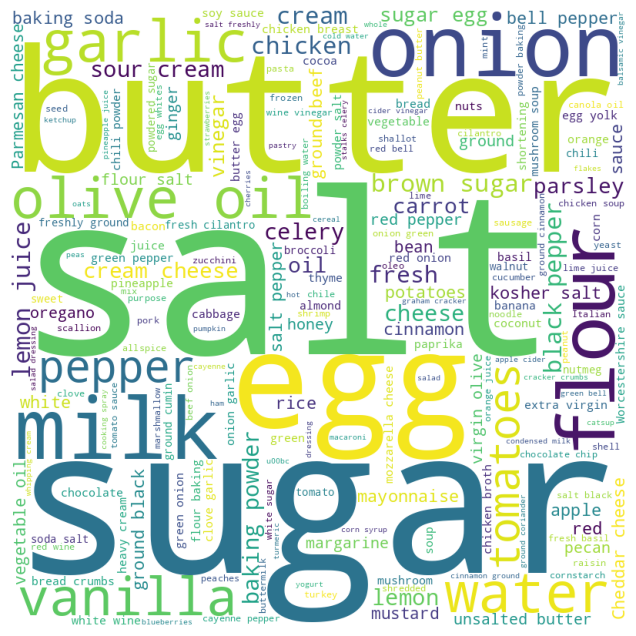

In [93]:
# Generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(' '.join(ingridients[:1000]))

# Display the word cloud using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### World Cloud of Unique Ingredients

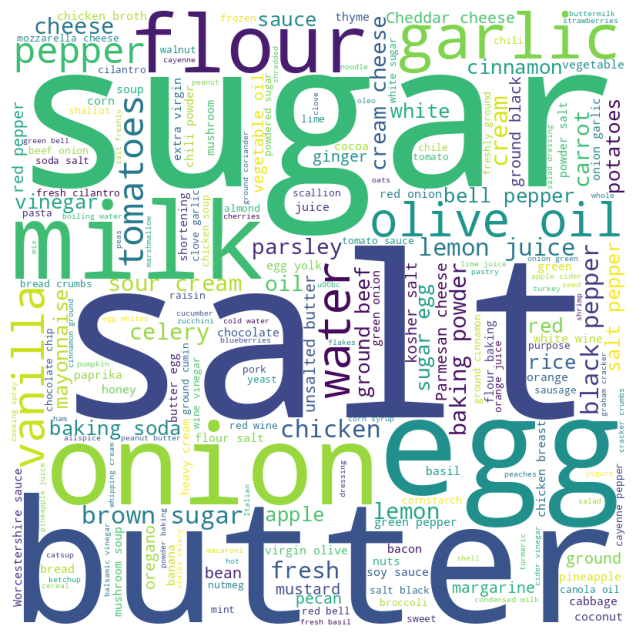

In [94]:
# Generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(' '.join(unique_NER_values[:1000]))

# Display the word cloud using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Tokenize Ingredients and Procedures for NLP Models

In [96]:
# Tokenizing only the ingredients
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['NER'])  # Use the NER column only. NER column contains the ingredients
ingredient_sequences = tokenizer.texts_to_sequences(df['NER'])
print(f"ingredient_sequences -> {ingredient_sequences[0:5]}")

# Calculate the length of each ingredient list
sequence_lengths = [len(seq) for seq in ingredient_sequences]

# Set max_sequence_length to a suitable value, e.g., 90th percentile
max_sequence_length = int(np.percentile(sequence_lengths, 90))

ingredient_sequences_padded = pad_sequences(ingredient_sequences, maxlen=max_sequence_length)


ingredient_sequences -> [[72, 14, 322, 30, 59], [109, 593, 4, 33, 37, 253, 44, 85], [45, 16, 8, 49, 93, 40, 8, 49, 16, 40, 9, 40, 13], [165, 189, 82, 11, 54, 213, 32, 113, 3, 1, 23, 19, 20, 5, 10, 16, 555, 22, 9, 37, 183, 22, 142, 523], [42, 8, 95, 8, 21, 18, 70, 1, 2, 11, 29, 3, 7, 4, 1, 1965]]


In [12]:
NUM_INGREDIENTS_COMBINATIONS = 10000
MAX_INGREDIENTS_PER_COMBINATIONS = 5

file_name = '/simulated_user_input_' + str(NUM_INGREDIENTS_COMBINATIONS) + '.csv'
simulated_data_file_path = path_base_dataset + file_name


### NOTE: A couple of cells in the following are not executed because the simulated dataset has already been generated and stored in the dataset directory

In [97]:
# # Assume df is your DataFrame containing the 'ingredients' column
# # For demonstration purposes, let's create a sample DataFrame with unique ingredients
# # In your case, replace this with your actual DataFrame
# # df = pd.read_csv('your_dataset.csv')  # Load your dataset

# # Create a sample ingredients list (replace this with actual unique ingredients)
# ingredients_list = unique_NER_values.tolist()  # Replace this with df['ingredients'].unique()

# # Function to generate random ingredient combinations
# def generate_random_combinations(ingredients_list, 
#                                  num_combinations=NUM_INGREDIENTS_COMBINATIONS,
#                                  max_ingredients_per_combination=MAX_INGREDIENTS_PER_COMBINATIONS):
#     combinations = []
#     for _ in range(num_combinations):
#         # Randomly select between 1 and max_ingredients_per_combination ingredients
#         num_ingredients = random.randint(1, max_ingredients_per_combination)
#         combination = random.sample(ingredients_list, num_ingredients)
#         combinations.append(', '.join(combination))  # Join selected ingredients into a string
#     return combinations

# # Generate 10,000 user input combinations
# user_input_combinations = generate_random_combinations(ingredients_list, 
#                                                        num_combinations=NUM_INGREDIENTS_COMBINATIONS)

# # Example: Print the first 10 combinations
# for i in range(10):
#     print(user_input_combinations[i])


["lemon jello", "cherry jello", "boiling water", "celery", "nuts", "pineapple", "cranberry sauce"]
["butter", "sugar", "flour", "milk", "eggs", "vanilla", "cream of tartar", "powdered sugar"], ["flour", "cornmeal", "sugar", "vegetable oil", "egg", "buttermilk", "frankfurters", "vegetable oil", "mustard", "catsup"], ["oats", "flour", "baking powder", "baking soda", "salt", "margarine", "peanut butter", "sugar", "brown sugar", "eggs", "vanilla", "chocolate chips"], ["pastry shell", "butter", "white sugar", "eggs", "vanilla", "white vinegar"], ["fresh spinach", "Chinese bean sprouts", "chestnuts", "eggs", "bacon"]
["nuts", "eggs", "sugar", "vegetable oil", "flour", "salt", "cinnamon", "baking powder", "zucchini", "vanilla", "raisins", "fruit cocktail"], ["onions", "baby carrots", "frozen corn", "vegetable broth", "red wine vinegar", "zucchini", "chickpeas", "light cream", "cornstarch", "kosher salt", "tomatoes", "asiago cheese", "white rice"]
["clams", "mushrooms", "egg", "onion", "saltin

In [98]:
# user_input_combinations_dict = {'user_input_simulated': user_input_combinations}
# df_user_input_sim = pd.DataFrame(user_input_combinations_dict)

# file_name = '/simulated_user_input_' + str(NUM_INGREDIENTS_COMBINATIONS) + '.csv'
# simulated_data_file_path = path_base_dataset + file_name

# df_user_input_sim.to_csv(simulated_data_file_path, index=False)

# df_check = pd.read_csv(simulated_data_file_path)
# df_check.head()

user_input_simulated
0  ["lemon jello", "cherry jello", "boiling water...
1  ["butter", "sugar", "flour", "milk", "eggs", "...
2  ["nuts", "eggs", "sugar", "vegetable oil", "fl...
3  ["clams", "mushrooms", "egg", "onion", "saltin...
4  ["condensed milk", "lime juice", "egg yolks", ...

### Loading the simulated dataset

In [13]:
df_check = pd.read_csv(simulated_data_file_path)
df_check.head()

user_input_simulated
0  ["lemon jello", "cherry jello", "boiling water...
1  ["butter", "sugar", "flour", "milk", "eggs", "...
2  ["nuts", "eggs", "sugar", "vegetable oil", "fl...
3  ["clams", "mushrooms", "egg", "onion", "saltin...
4  ["condensed milk", "lime juice", "egg yolks", ...

In [100]:
# string representation of list to list using ast.literal_eval()
# import ast

print(f"NER -> {df['NER'].head(5)}")

# Convert the string representation of lists to actual lists
# df['ingredients_list'] = df['NER'].apply(ast.literal_eval)
df['ingredients_list'] = df['NER'].apply(literal_eval)
print(f"ingredients_list -> {df['ingredients_list'].head(5)}")

# Convert the ingredients to a single string for each recipe
df['ingredients_str'] = df['ingredients_list'].apply(lambda x: ' '.join(x))
print(f"ingredients_str -> {df['ingredients_str'].head(5)}")



NER -> 1254789    ["bacon", "eggs", "buns", "tomatoes", "mayonna...
2162678    ["bay scallops", "butter", "onions", "parsley"...
832049     ["rice", "chicken", "cream of mushroom soup", ...
1396186    ["coriander", "allspice", "cumin", "ground gin...
1322877    ["sour cream", "heavy cream", "baking powder",...
Name: NER, dtype: object


ingredients_list -> 1254789            [bacon, eggs, buns, tomatoes, mayonnaise]
2162678    [bay scallops, butter, onions, parsley, lemons...
832049     [rice, chicken, cream of mushroom soup, cream ...
1396186    [coriander, allspice, cumin, ground ginger, tu...
1322877    [sour cream, heavy cream, baking powder, koshe...
Name: ingredients_list, dtype: object
ingredients_str -> 1254789                  bacon eggs buns tomatoes mayonnaise
2162678    bay scallops butter onions parsley lemons brea...
832049     rice chicken cream of mushroom soup cream of c...
1396186    coriander allspice cumin ground ginger turmeri...
1322877    sour cream heavy cream baking powder kosher sa...
Name: ingredients_str, dtype: object


### TFIDF Vectorizer Fitting & Function for Calculating Cosine Similarities

In [101]:
# Fit a TF-IDF Vectorizer on the ingredients
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['ingredients_str'])

# Example: Print the shape of the TF-IDF matrix
print(tfidf_matrix.shape)  # Output: (number of recipes, number of unique words)

# Function to compute similarity scores
def compute_similarity(user_ingredients, tfidf, tfidf_matrix):
    user_tfidf = tfidf.transform([user_ingredients])
    cosine_sim = cosine_similarity(user_tfidf, tfidf_matrix)
    return cosine_sim.flatten()



(50000, 5269)


### Computation of the similarity scores associated with the input data

In [102]:
# Example user ingredients
user_ingredients = "chicken garlic onion salt pepper"
similarity_scores_test = compute_similarity(user_ingredients, tfidf, tfidf_matrix)
print(similarity_scores_test)

# Example: Print the top 5 most similar recipes
top_indices = similarity_scores_test.argsort()[-5:][::-1]
print(df.iloc[top_indices][['ingredients_str']])

[0.         0.         0.25358291 ... 0.19422614 0.08762968 0.03156691]
                                           ingredients_str
261129             chicken butter onion salt garlic pepper
751413                           chicken salt onion garlic
1058570  Garlic butter garlic black pepper lemon juice ...
1904104                                 Garlic Salt Pepper
1779288                           garlic garlic onion salt


### Building & compiling the initial LSTM model

In [103]:
# embedding_dim = 300  # Size of the embedding vector
# lstm_units = 128      # Number of LSTM units
EMBEDDING_DIM = 300  # Size of the embedding vector
LSTM_UNITS = 128      # Number of LSTM units


model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, 
                    output_dim=EMBEDDING_DIM, 
                    input_length=max_sequence_length))
model.add(LSTM(LSTM_UNITS, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Computation of the similarity scores on the simulated dataset

In [104]:
df_user_input = pd.read_csv(simulated_data_file_path)

# Iterate over the loaded data to preprocess and compute similarity scores
for index, row in df_user_input.iterrows():
    user_ingredients = row['user_input_simulated']
    user_ingredients_list = [ingredient.strip() for ingredient in user_ingredients.split(',')]
    user_ingredients_str = ' '.join(user_ingredients_list)
    print(user_ingredients_str)
    
    # Compute similarity scores
    similarity_scores = compute_similarity(user_ingredients_str, tfidf, tfidf_matrix)

    # Print the similarity scores
    print(similarity_scores)


["lemon jello" "cherry jello" "boiling water" "celery" "nuts" "pineapple" "cranberry sauce"]
[0.         0.         0.02326722 ... 0.         0.         0.02392237]
["butter" "sugar" "flour" "milk" "eggs" "vanilla" "cream of tartar" "powdered sugar"] ["flour" "cornmeal" "sugar" "vegetable oil" "egg" "buttermilk" "frankfurters" "vegetable oil" "mustard" "catsup"] ["oats" "flour" "baking powder" "baking soda" "salt" "margarine" "peanut butter" "sugar" "brown sugar" "eggs" "vanilla" "chocolate chips"] ["pastry shell" "butter" "white sugar" "eggs" "vanilla" "white vinegar"] ["fresh spinach" "Chinese bean sprouts" "chestnuts" "eggs" "bacon"]
[0.13332692 0.03242407 0.07105516 ... 0.10106514 0.09834612 0.16301454]
["nuts" "eggs" "sugar" "vegetable oil" "flour" "salt" "cinnamon" "baking powder" "zucchini" "vanilla" "raisins" "fruit cocktail"] ["onions" "baby carrots" "frozen corn" "vegetable broth" "red wine vinegar" "zucchini" "chickpeas" "light cream" "cornstarch" "kosher salt" "tomatoes" "a

[0.02250773 0.02437349 0.04864175 ... 0.11774839 0.07120394 0.15102655]
["vegetable oil" "onions" "garlic" "jalapeno chilies" "tomatoes" "tomato paste" "green bell peppers" "carrots" "ground cumin" "salt" "cayenne pepper" "kidney beans" "pinto beans" "zucchini" "cheddar cheese" "onions"] ["fish" "onions" "tomatoes" "lentils" "coriander" "cumin" "white pepper" "water" "ghee" "curry" "lime juice"] ["brownie mix" "chocolate mousse" "Butterfingers"] ["milk" "banana" "milk" "brown sugar" "vanilla"] ["olive oil" "onions" "carrots" "zucchini" "green beans" "tomatoes" "garlic" "potatoes" "chicken broth" "chickpeas" "salt" "black pepper" "basil" "olive oil" "garlic" "chicken broth low-fat" "salt" "black pepper" "parmesan"]
[0.07481985 0.07679953 0.05398367 ... 0.19544006 0.18533487 0.08920703]
["CHICKEN DUMPLINGS" "ground chicken" "fresh cilantro" "fresh basil" "chili" "fresh ginger" "fish sauce" "chicken stock" "fresh ginger" "fish sauce" "stalk lemongrass" "garlic" "daikon radishes" "carrots"

### LSTM model training

In [105]:
# Assuming ingredient_sequences is your padded input for recipes
model.fit(ingredient_sequences_padded, similarity_scores, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 0.0065 - mean_absolute_error: 0.0368 - val_loss: 1.6964e-04 - val_mean_absolute_error: 0.0073
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 9.3334e-05 - mean_absolute_error: 0.0062 - val_loss: 7.6106e-05 - val_mean_absolute_error: 0.0052
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 5.2452e-05 - mean_absolute_error: 0.0047 - val_loss: 7.7097e-05 - val_mean_absolute_error: 0.0052
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 5.2587e-05 - mean_absolute_error: 0.0042 - val_loss: 7.6274e-05 - val_mean_absolute_error: 0.0050
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 4.2149e-05 - mean_absolute_error: 0.0041 - val_loss: 5.4314e-05 - val_mean_absolute_error: 0.0038
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 3.7416e-05 - mean_absolute_error: 0.0037 - val_loss: 5.5094e-05 - val_mean_absolute_error: 0.0037
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1

### Model inference & making predictions

In [106]:
# Assuming the model has already been trained
predictions = model.predict(ingredient_sequences_padded)

# Flatten predictions if necessary
if predictions.ndim > 1:
    predictions = predictions.flatten()

# Generate recommendations based on predictions
recommended_indices = predictions.argsort()[-5:][::-1]  # Get indices of top 5 recommendations
recommended_recipes = df.iloc[recommended_indices]
print(recommended_recipes)

 173/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
              ID                                   name  \
598330    598330             Harvard Beets(Microwave)     
49175      49175                          Harvard Beets   
32331      32331                          Harvard Beets   
211801    211801                          Harvard Beets   
2123932  2123932  Best In The World Beet Pickles Recipe   

                                               ingredients  \
598330   ["1/2 c. sugar", "1/2 tsp. salt", "dash of pep...   
49175    ["1 (1 lb.) can sliced beets or 1 quart frozen...   
32331    ["4 Tbsp. butter", "2 Tbsp. flour", "3 Tbsp. s...   
211801   ["1 can diced beets", "1/3 c. sugar", "2 tsp. ...   
2123932  ["Beets (sufficient to fill one large kettle)"...   

                                                 procedure  \
598330   ["In a 1-quart casserole dish, combine sugar, ...   
49175    ["Drain beets; save 1/4 cup of the liquid.", "...   
32331    ["Melt butter in top of double boi